In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('flight_data.csv')

In [3]:
df.head()

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"
3,15/01/2023,16/01/2023,SpiceJet \nSG-8709\nECONOMY,18:50\nDelhi,20:55\nMumbai,02h 05m,non-stop,"5,794"
4,15/01/2023,16/01/2023,Air India \nAI-805\nECONOMY,20:00\nDelhi,22:10\nMumbai,02h 10m,non-stop,"5,955"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Date of Booking  452088 non-null  object
 1   Date of Journey  452088 non-null  object
 2   Airline-Class    452088 non-null  object
 3   Departure Time   452088 non-null  object
 4   Arrival Time     452088 non-null  object
 5   Duration         452088 non-null  object
 6   Total Stops      452088 non-null  object
 7   Price            452088 non-null  object
dtypes: object(8)
memory usage: 27.6+ MB


In [5]:
df.isnull().sum()

Date of Booking    0
Date of Journey    0
Airline-Class      0
Departure Time     0
Arrival Time       0
Duration           0
Total Stops        0
Price              0
dtype: int64

# Data Cleaning

In [6]:
def clean_flight_data(df):
    
    #Airline Class
    df['Airline-Name']=df['Airline-Class'].str.split('\n').str[0].str.strip()

     
    df['Class'] = df['Airline-Class'].str.split('\n').str[-1].str.strip()
    
    #journey date
    df['Date of Journey']=pd.to_datetime(df['Date of Journey'],format='%d/%m/%Y')
    
    #date of booking 
    df['Date of Booking']=pd.to_datetime(df['Date of Booking'],format='%d/%m/%Y')
    
    #days before flight
    df['days_before_flight']=(df['Date of Journey']-df['Date of Booking']).dt.days
    
    # day of booking
    df['journey_day']=df['Date of Journey'].dt.day
    
    df['journey_day_name']=df['Date of Journey'].dt.day_name()
    
   
    
    # Departure City
    df['Departure City']=df['Departure Time'].str.split('\n').str[1].str.strip()    
    
    # Arrival City
    df['Arrival City']=df['Arrival Time'].str.split('\n').str[1].str.strip()
    
    
    #TotalStops Cleanup
    df['Total Stops'] = df['Total Stops'].str.replace(r'\n\s*\t*', '', regex=True)
    df['Total Stops'] = df['Total Stops'].str.replace(r'(stop).*', r'\1', regex=True)
    
    #Departure Time
    df['Departure_Time']=df['Departure Time'].str.split('\n').str[0].str.strip()
    
    #Arrival Time
    df['Arrival_Time']=df['Arrival Time'].str.split('\n').str[0].str.strip()
    
    #Duration
    df['Duration'] = df['Duration'].str.extract(r'(\d+)h (\d+)m') \
                                     .astype(float) \
                                     .apply(lambda x: round(x[0] + x[1] / 60, 4), axis=1)
    # Extract hour from 'arrival' column
    df['arrival_time'] = pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.hour

    # Categorize arrivals based on the hour
    df['arrival_category'] = df['arrival_time'].apply(lambda x: 'Before 7pm' if x < 19 else 'After 7pm')
                            
    #drop columns
    df.drop(['Date of Booking','Date of Journey','Airline-Class','Departure Time','Arrival Time','arrival_time'],axis=1,inplace=True)
                            
    df['Price'] = df['Price'].replace(',', '', regex=True).astype(int)
    return df

In [7]:
df = clean_flight_data(df)

In [8]:
df.sample(4)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,Departure City,Arrival City,Departure_Time,Arrival_Time,arrival_category
33919,2.9167,non-stop,5241,Air India,ECONOMY,43,27,Monday,Delhi,Bangalore,13:30,16:25,Before 7pm
182429,5.3333,1-stop,8710,Indigo,ECONOMY,4,19,Thursday,Bangalore,Mumbai,07:25,12:45,Before 7pm
379649,11.2500,1-stop,44304,Vistara,BUSINESS,26,10,Friday,Chennai,Bangalore,20:30,07:45,Before 7pm
174917,7.8333,1-stop,8327,Indigo,ECONOMY,32,16,Thursday,Bangalore,Delhi,23:40,07:30,Before 7pm


## Feature Engineering

In [9]:
def feat_eng(df):
    #concatenate route
    df['Route'] = df['Departure City'] + ' -> ' + df['Arrival City']
    
    #drop appended columns above
    df.drop(['Departure City','Arrival City'],axis=1,inplace=True)
    
    
    ## Convert Departure and Arrival to the hr
    df['Departure_Time_hr']=pd.to_datetime(df['Departure_Time'], format='%H:%M').dt.hour
    df['Arrival_Time_hr']=pd.to_datetime(df['Arrival_Time'], format='%H:%M').dt.hour
    
    df.drop(['Departure_Time','Arrival_Time'],axis=1,inplace=True)
    
    
    
    return(df)
    

In [10]:
df=feat_eng(df)

In [11]:
df.sample(2)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
135267,11.4167,1-stop,12558,Vistara,ECONOMY,24,8,Wednesday,Before 7pm,Mumbai -> Kolkata,20,8
170501,5.6667,1-stop,5658,AirAsia,ECONOMY,20,4,Saturday,Before 7pm,Bangalore -> Delhi,5,10


In [13]:
df=df[(df['Airline-Name']=='Air India') & (df['Class']=='ECONOMY')  & (df['Route']=='Delhi -> Mumbai') ]

In [14]:
df.sample(2)

,Duration,Total Stops,Price,Airline-Name,Class,days_before_flight,journey_day,journey_day_name,arrival_category,Route,Departure_Time_hr,Arrival_Time_hr
16519,10.1667,1-stop,8614,Air India,ECONOMY,44,28,Tuesday,Before 7pm,Delhi -> Mumbai,22,8
8509,11.7500,1-stop,7194,Air India,ECONOMY,23,7,Tuesday,After 7pm,Delhi -> Mumbai,9,21


In [15]:
# drop airline name and class after filtering
df.drop(['Class','Airline-Name','Route'],inplace=True,axis=1)

######  Encoding

In [18]:
def enc_data(df):
    # Total Stops
    df=pd.get_dummies(df, columns=['Total Stops'], prefix='Stops',dtype=int)  
      

    
    # frequency coding journey day name
    frequency_map = df['journey_day_name'].value_counts(normalize=True).to_dict()
    df['journey_day_name_FreqEnc'] = df['journey_day_name'].map(frequency_map)
    
    df.drop(['journey_day_name'],axis=1,inplace=True)
    
    #label encoding arrival_category
    label_encoder = LabelEncoder()
    df['arrival_category'] = label_encoder.fit_transform(df['arrival_category'])
    
        
    return (df)    

In [19]:
enc_df=enc_data(df)

In [20]:
enc_df.sample(3)

,Duration,Price,days_before_flight,journey_day,arrival_category,Departure_Time_hr,Arrival_Time_hr,Stops_1-stop,Stops_non-stop,journey_day_name_FreqEnc
12623,2.2500,5955,34,18,1,22,0,0,1,0.147027
7323,22.0833,7704,20,4,1,16,14,1,0,0.147027
10886,22.0833,7704,29,13,1,16,14,1,0,0.165268


## Modeling - Xgboost Regressor

In [21]:
# Predictor & target variables
X=enc_df.drop(['Price',],axis=1)
y=enc_df['Price']
    
#split the dataset for train&test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
    

In [25]:
def xgboostmodel(enc_df):
    
    
    model = xgb.XGBRegressor(learning_rate= 0.06375277732583517, 
                             max_depth= 7, 
                             subsample= 0.7753243552829342, 
                             colsample_bytree= 0.7687203075487558,
                             min_child_weight=1)
    model.fit(X_train, y_train)

    
    return model

In [26]:
model = xgboostmodel(enc_df)
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7687203075487558, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06375277732583517, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
predicted_prices=model.predict(X_test)
predicted_prices

array([13552.967 ,  9231.648 ,  7823.9976,  8440.58  ,  6439.6704,
        7369.7925,  6697.033 ,  8092.316 ,  8935.881 , 12451.044 ,
        5986.161 ,  6795.8296,  6376.85  ,  7560.8643,  6314.187 ,
        7860.062 ,  7958.7314,  7100.5796,  5996.551 ,  9921.33  ,
        8680.655 ,  5875.023 ,  5984.6636,  7501.4087,  7788.218 ,
       15561.026 ,  6306.9097, 12068.682 , 15577.072 ,  5993.992 ,
        7934.2876,  9524.572 ,  9275.721 ,  7716.8965, 18972.533 ,
        8414.165 ,  7060.195 ,  8646.319 , 12142.234 ,  9347.796 ,
        7336.8765,  8645.416 ,  8216.954 , 13088.866 ,  5912.154 ,
        6256.959 ,  9628.788 , 12286.393 ,  7888.719 , 16260.137 ,
        6525.168 ,  7958.3433,  7721.0015,  7103.193 ,  8134.892 ,
        7972.3613,  9136.446 ,  5884.6504, 11580.94  , 12092.595 ,
       10268.919 ,  8392.385 ,  9498.133 ,  9783.861 ,  8585.214 ,
        9311.856 ,  8701.956 , 10581.897 ,  8464.906 ,  9719.116 ,
        9721.205 ,  9017.456 ,  8189.6104,  8961.769 , 15026.5

In [28]:
r2 = r2_score(y_test, predicted_prices)
print('r2 is',r2)

rmse = mean_squared_error(y_test,predicted_prices, squared=False)
print('rmse is',rmse)

r2 is 0.8343022254417948
rmse is 1493.8250564531593


## Feature Importance

In [29]:
# Get feature importance scores
feature_importance =model.feature_importances_

# Create a DataFrame to display feature importance scores
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
0,Duration,0.205578
5,Arrival_Time_hr,0.178101
6,Stops_1-stop,0.167364
3,arrival_category,0.151552
4,Departure_Time_hr,0.119683
1,days_before_flight,0.084426
8,journey_day_name_FreqEnc,0.037725
2,journey_day,0.033443
7,Stops_non-stop,0.022129


## Hyper Parameter Tuning

In [22]:
#!pip install optuna
import optuna

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 300,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.01,0.1),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
        
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-02-19 09:03:02,465] A new study created in memory with name: no-name-b656b50a-9594-42a8-90bb-82ab285e60f7
[I 2024-02-19 09:03:02,666] Trial 0 finished with value: 1514.236720645318 and parameters: {'learning_rate': 0.08991803056994999, 'max_depth': 6, 'subsample': 0.4697920132993561, 'colsample_bytree': 0.3765608124452449, 'min_child_weight': 12}. Best is trial 0 with value: 1514.236720645318.
[I 2024-02-19 09:03:02,893] Trial 1 finished with value: 1536.5877923535502 and parameters: {'learning_rate': 0.07069044096939966, 'max_depth': 7, 'subsample': 0.4768348668272562, 'colsample_bytree': 0.3444881904045838, 'min_child_weight': 12}. Best is trial 0 with value: 1514.236720645318.
[I 2024-02-19 09:03:03,037] Trial 2 finished with value: 1810.9189890204166 and parameters: {'learning_rate': 0.08936934178273871, 'max_depth': 4, 'subsample': 0.1912682195622255, 'colsample_bytree': 0.8304935591646032, 'min_child_weight': 20}. Best is trial 0 with value: 1514.236720645318.
[I 2024-02-

[I 2024-02-19 09:03:14,163] Trial 28 finished with value: 1422.1662656327803 and parameters: {'learning_rate': 0.07623521496498104, 'max_depth': 9, 'subsample': 0.5902509192614913, 'colsample_bytree': 0.9941784655263637, 'min_child_weight': 3}. Best is trial 23 with value: 1374.0321011396609.
[I 2024-02-19 09:03:14,408] Trial 29 finished with value: 1518.3326561028032 and parameters: {'learning_rate': 0.08320368728696753, 'max_depth': 6, 'subsample': 0.4982356909064227, 'colsample_bytree': 0.44396800961798183, 'min_child_weight': 11}. Best is trial 23 with value: 1374.0321011396609.


In [24]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)



Best hyperparameters: {'learning_rate': 0.06375277732583517, 'max_depth': 7, 'subsample': 0.7753243552829342, 'colsample_bytree': 0.7687203075487558, 'min_child_weight': 1}
Best RMSE: 1374.0321011396609


In [30]:
import numpy as np
from scipy.optimize import minimize

# Calculate revenue before optimization
revenue_before = np.sum(predicted_prices)

# Define the objective function (maximize revenue)
def objective_function(prices):
    revenue = -np.sum(prices)  
    return revenue

# Define constraints
def constraint(prices, predicted_prices, min_revenue):
    return np.concatenate([prices - predicted_prices, predicted_prices * 1.2 - prices, [np.sum(prices) - min_revenue]])

# Define initial prices (use predicted prices as initial guess)
initial_prices = predicted_prices

# Minimum revenue constraint
min_revenue = np.sum(predicted_prices) * 0.9  



# Adjust constraints to ensure prices are no lower than predicted and no greater than 1.2 times predicted
bounds = [(price, price * 1.2) for price in predicted_prices]

# Perform optimization
result = minimize(objective_function, initial_prices, constraints={'type': 'ineq', 'fun': constraint, 'args': (predicted_prices, min_revenue)}, bounds=bounds)

# Get optimized prices
optimized_prices = result.x

# Calculate revenue after optimization
revenue_after = np.sum(optimized_prices)

# Print revenue before and after optimization
print("Revenue before optimization:", revenue_before)
print("Revenue after optimization:", revenue_after)


Revenue before optimization: 5190586.0
Revenue after optimization: 6227234.736910784


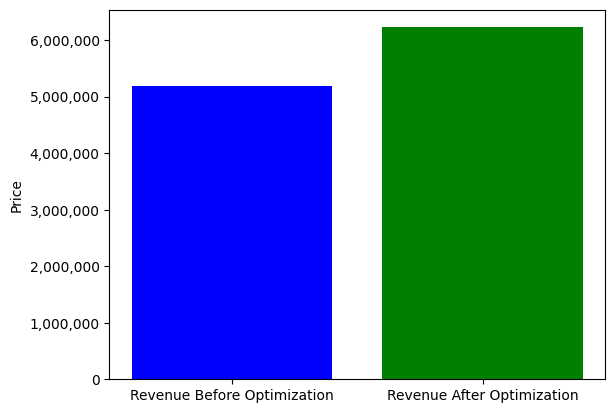

In [35]:
# Define revenue before and after optimization
revenue_values = [revenue_before, revenue_after]

# Define labels for the bars
labels = ['Revenue Before Optimization', 'Revenue After Optimization']


# Plotting
plt.bar(labels, revenue_values, color=['blue', 'green'])
plt.ylabel('Price')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [32]:
prices_df = pd.DataFrame({
    'Predicted Prices': predicted_prices,
    'Optimized Prices': optimized_prices
})
prices_df

,Predicted Prices,Optimized Prices
0,13552.966797,16263.560137
1,9231.648438,11077.978110
2,7823.997559,9388.797057
3,8440.580078,10128.696080
4,6439.670410,7727.604480
5,7369.792480,8843.750964
6,6697.033203,8036.439831
7,8092.315918,9710.779088
8,8935.880859,10723.057017
9,12451.043945,14941.252716


Text(0.5, 1.0, 'Distribution of Predicted and Optimized Prices')

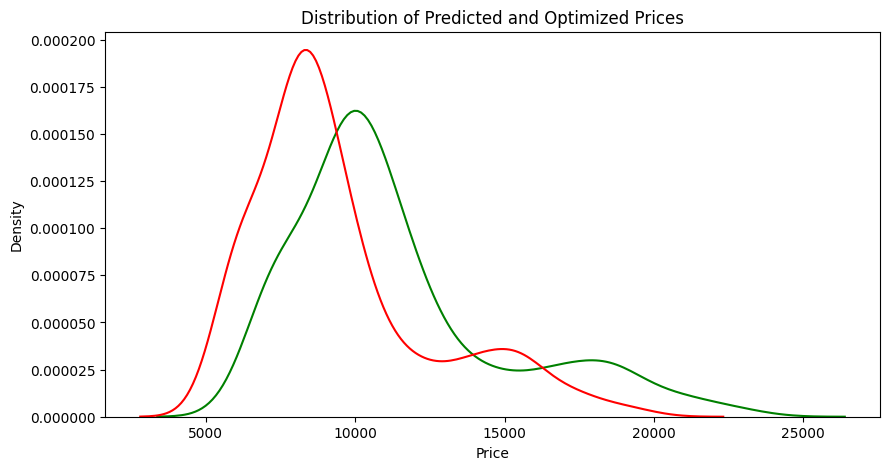

In [33]:
from matplotlib.pyplot import figure

#set size
figure(figsize=(10,5))
       
sns.kdeplot(x=optimized_prices, label='Optimized Prices',color='green')
sns.kdeplot(x=predicted_prices, label='Predicted Prices',color='red')

plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Predicted and Optimized Prices')